# Chapter 13: Portfolio Management System

In [3]:
# Chapter 13: Portfolio Management System

import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt

#### Days to liquidate 

In [4]:
# Chapter 13: Portfolio Management System

ticker = 'UNG'
volume = yf.download(tickers= ticker,start= '2021-01-01', end = None,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True, 
                 treads = True, proxy = None)['Volume']


def days_liquidation(quantity,volume,window,fraction):
    avg_vol_fraction = volume.rolling(window).mean() * fraction
    return round(quantity/avg_vol_fraction,2)
quantity = 100000
window = 63
fraction =0.01

days_liquidation(quantity,volume,window,fraction)[-1]


[*********************100%***********************]  1 of 1 completed


2.37

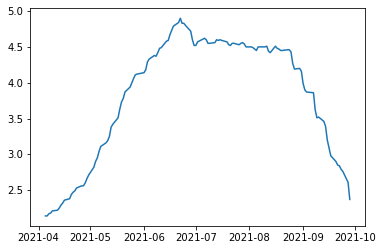

In [5]:
plt.plot(days_liquidation(quantity,volume,window,fraction))

### Portfolio simulation
From Chapter 11
1. Hypothetical portfolio is benchmarked to the S&P 500 index
2. Initial capital (K) is set at USD 1 million
3. Beta (sensitivity to the market) has been extracted from the Yahoo Finance website
4. The number of shares and relative stop losses are calibrated to -0.50% relative risk adjusted to the portfolio
4. The portfolio is run from December 31, 2020, through June 30, 2021

In [6]:
# Chapter 13: Portfolio Management System

K = 1000000
lot = 100
port_tickers = ['QCOM','TSLA','NFLX','DIS','PG', 'MMM','IBM','BRK-B','UPS','F']
bm_ticker= '^GSPC'
tickers_list = [bm_ticker] + port_tickers
df_data= { 
'Beta':[1.34,2,0.75,1.2,0.41,0.95,1.23,0.9,1.05,1.15],
'Shares':[-1900,-100,-400,-800,-5500,1600,1800,2800,1100,20800],
'rSL':[42.75,231,156,54.2,37.5,42.75,29.97,59.97,39.97,2.10]
}
port = pd.DataFrame(df_data,index=port_tickers)
port['Side'] = np.sign(port['Shares'])

start_dt = '2021-01-01'
end_dt = '2021-07-01'
price_df = round( yf.download(tickers= tickers_list,start= '2021-01-01' , end = '2021-07-01', 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, treads = True, proxy = None)['Close'],2)

bm_cost = price_df[bm_ticker][0]
bm_price = price_df[bm_ticker][-1]

port['rCost'] = round(price_df.iloc[0,:].div(bm_cost) *1000,2)
port['rPrice'] = round(price_df.iloc[-1,:].div(bm_price) *1000,2)
port['Cost'] = price_df.iloc[0,:]
port['Price'] = price_df.iloc[-1,:]

print(port)

[*********************100%***********************]  11 of 11 completed
       Beta  Shares     rSL  Side   rCost  rPrice    Cost   Price
QCOM   1.34   -1900   42.75    -1   39.55   33.11  146.36  142.27
TSLA   2.00    -100  231.00    -1  197.20  158.16  729.77  679.70
NFLX   0.75    -400  156.00    -1  141.29  122.91  522.86  528.21
DIS    1.20    -800   54.20    -1   48.01   40.90  177.68  175.77
PG     0.41   -5500   37.50    -1   36.55   31.20  135.27  134.09
MMM    0.95    1600   42.75     1   45.38   45.87  167.94  197.13
IBM    1.23    1800   29.97     1   32.31   33.72  119.58  144.92
BRK-B  0.90    2800   59.97     1   61.73   64.67  228.45  277.92
UPS    1.05    1100   39.97     1   43.54   48.14  161.14  206.88
F      1.15   20800    2.10     1    2.30    3.46    8.52   14.86


In Chapter 12, Signals and Execution, we worked on the port dataframe. This time, we will visualize exposures using price_df.

In [7]:
# Chapter 13: Portfolio Management System

price_df['bm returns'] = round(np.exp(np.log(price_df[bm_ticker]/price_df[bm_ticker].shift()).cumsum()) - 1, 3)
rel_price = round(price_df.div(price_df['^GSPC'],axis=0 )*1000,2)

rMV = rel_price.mul(port['Shares'])
rLong_MV = rMV[rMV >0].sum(axis=1)
rShort_MV = rMV[rMV <0].sum(axis=1)
rMV_Beta = rMV.mul(port['Beta'])
rLong_MV_Beta = rMV_Beta[rMV_Beta >0].sum(axis=1) / rLong_MV
rShort_MV_Beta = rMV_Beta[rMV_Beta <0].sum(axis=1)/ rShort_MV

price_df['rNet_Beta'] = rLong_MV_Beta - rShort_MV_Beta
price_df['rNet'] = round((rLong_MV + rShort_MV).div(abs(rMV).sum(axis=1)),3)

price_df['rReturns_Long'] = round(np.exp(np.log(rLong_MV/rLong_MV.shift()).cumsum())-1,3)
price_df['rReturns_Short'] = - round(np.exp(np.log(rShort_MV/rShort_MV.shift()).cumsum())-1,3)
price_df['rReturns'] = price_df['rReturns_Long'] + price_df['rReturns_Short']

MV = price_df.mul(port['Shares'])
Long_MV = MV[MV >0].sum(axis=1)
Short_MV = MV[MV <0].sum(axis=1)
price_df['Gross'] = round((Long_MV - Short_MV).div(K),3)
price_df['Net'] = round((Long_MV + Short_MV).div(abs(MV).sum(axis=1)),3)

price_df['Returns_Long'] = round(np.exp(np.log(Long_MV/Long_MV.shift()).cumsum())-1,3)
price_df['Returns_Short'] = - round(np.exp(np.log(Short_MV/Short_MV.shift()).cumsum())-1,3)
price_df['Returns'] = price_df['Returns_Long'] + price_df['Returns_Short']

MV_Beta = MV.mul(port['Beta'])
Long_MV_Beta = MV_Beta[MV_Beta >0].sum(axis=1) / Long_MV
Short_MV_Beta = MV_Beta[MV_Beta <0].sum(axis=1)/ Short_MV
price_df['Net_Beta'] = Long_MV_Beta - Short_MV_Beta




### Exposures and returns vizualisation


1. The "who are you" chart: market returns and exposures:
    1. Benchmark returns
    2. Returns
    3. Gross exposure
    4. relative net Beta
    5. relative net exposure
    

2. Returns: benchmark, absolute, relative, long and short
    1. Benchmark returns
    2. Returns
    3. Relative returns
    4. Relative Long returns
    5. Relative Short returns
    
    
3. Returns: benchmark, absolute, relative, long and short
    1. Benchmark returns
    2. Returns
    3. Relative returns
    4. Relative Long returns
    5. Relative Short returns
    6. Long returns
    7. Short returns
    
    
4. Returns: benchmark, absolute, relative, long and short
    1. Benchmark returns
    2. Relative returns
    3. Relative Long returns
    4. Relative Short returns
    5. Long returns
    6. Short returns

<AxesSubplot:title={'center':'Returns: benchmark, Long / Short absolute & relative'}, xlabel='Date'>

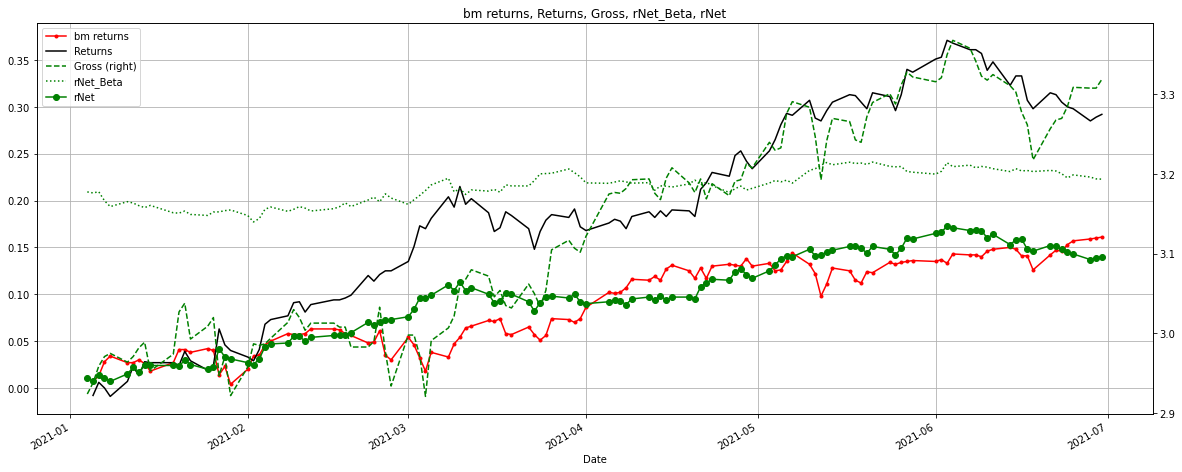

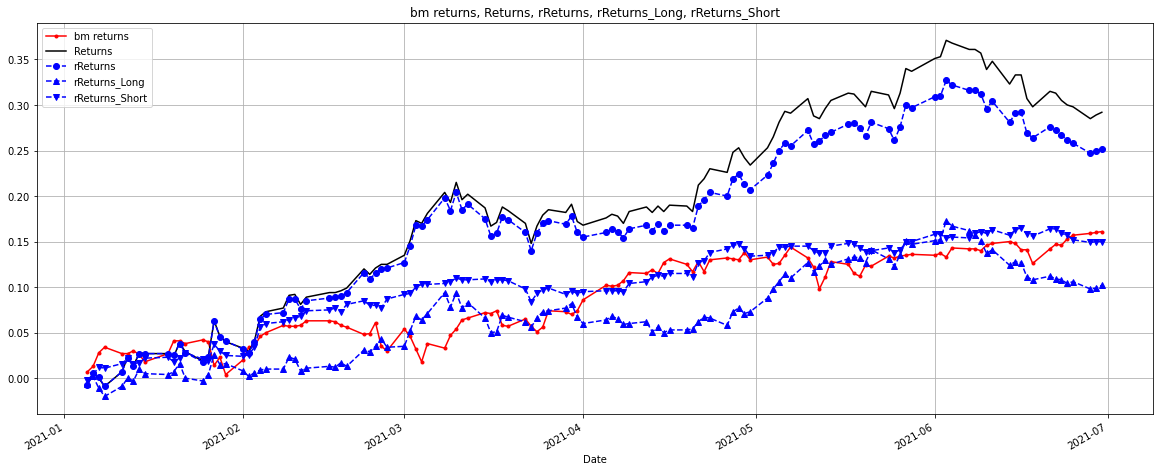

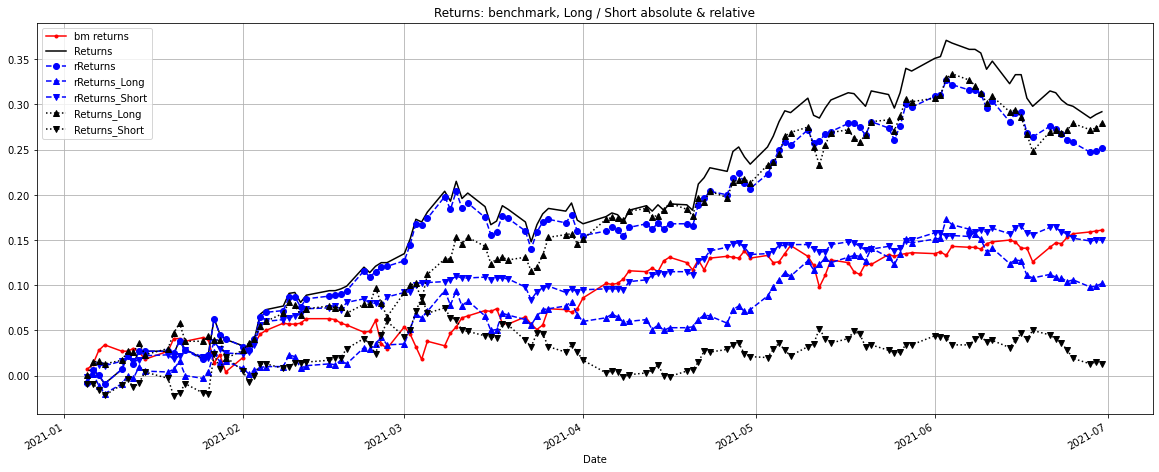

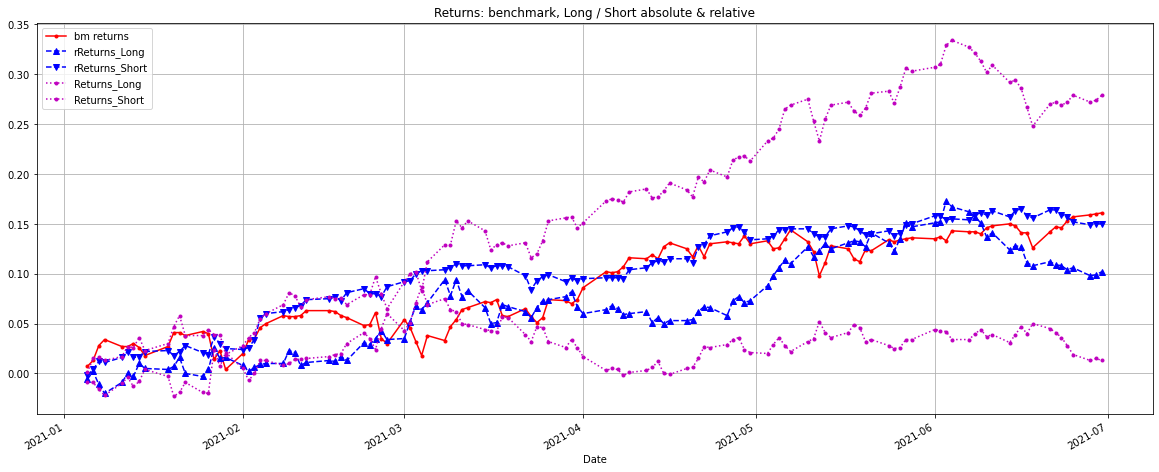

In [8]:
# Chapter 13: Portfolio Management System

price_df[['bm returns','Returns','Gross','rNet_Beta','rNet' ]].plot(
    figsize=(20,8),grid=True, secondary_y=['Gross'],
    style= ['r.-','k','g--','g:','g-o','b:','c','c:'],
    title = 'bm returns, Returns, Gross, rNet_Beta, rNet')

price_df[['bm returns','Returns','rReturns','rReturns_Long','rReturns_Short']].plot(
    figsize=(20,8),grid=True,
     style= ['r.-','k','b--o','b--^','b--v','g-.','g:','b:'],
title= 'bm returns, Returns, rReturns, rReturns_Long, rReturns_Short')

price_df[['bm returns','Returns','rReturns',
          'rReturns_Long','rReturns_Short','Returns_Long','Returns_Short']].plot(
            figsize=(20,8),grid=True,secondary_y=['Gross'], 
            style= ['r.-','k','b--o','b--^','b--v','k:^','k:v',],
title= 'Returns: benchmark, Long / Short absolute & relative')

price_df[['bm returns',
          'rReturns_Long','rReturns_Short','Returns_Long','Returns_Short']].plot(
            figsize=(20,8),grid=True,secondary_y=['Gross'], 
            style= ['r.-','b--^','b--v','m:.','m:.',],
title= 'Returns: benchmark, Long / Short absolute & relative')




In [9]:
# Chapter 13: Portfolio Management System

adjust_long = adjust_short  =  -0.01 

MV = port['Shares'] * port['Price']
port['Weight'] = round(MV.div(abs(MV).sum()), 3)
port['rR'] = (port['rCost'] - port['rSL'])
port['rRisk'] = -round(np.maximum(0,(port['rR'] * port['Shares'])/K), 4)
port['rRAR'] = round( (port['rPrice'] - port['rCost'])/port['rR'], 1)
port['rCTR'] = round(port['Shares'] * (port['rPrice']-port['rCost'])/
K,4)
port['CTR'] = round(port['Shares'] * (port['Price']-port['Cost'])/ K,4)

port_long = port[port['Side'] > 0]
port_short = port[port['Side'] < 0]
pro_rata_long = port_long['rRisk'] / (port_long['rRisk'].sum() * port_long['rRAR'])
risk_adj_long = (abs(adjust_long) * pro_rata_long * K / port_long['rR'] // lot) * lot
shares_adj_long =  np.minimum(risk_adj_long, port_long['Shares'])*np.sign(adjust_long)

pro_rata_short = port_short['rRisk'] / (port_short['rRisk'].sum() * port_short['rRAR'])
risk_adj_short = (abs(adjust_short) * pro_rata_short * K / port_short['rR'] // lot)*lot
shares_adj_short = np.maximum(risk_adj_short,port_short['Shares'])*np.sign(adjust_short)

port['Qty_adj'] = shares_adj_short.append(shares_adj_long)
port['Shares_adj']  = port['Shares'] + port['Qty_adj']
port['rRisk_adj'] = -round(np.maximum(0,(port['rR'] * port['Shares_adj'])/K),4)
MV_adj= port['Shares_adj'] * port['Price']
rMV_adj = port['Shares_adj'] * port['rPrice']
port['Weight_adj'] = round(MV_adj.div(abs(MV_adj).sum()),3)

print(port[['Side','rRAR','rRisk','rRisk_adj','Shares','Qty_adj', 'Shares_adj', 'Weight','Weight_adj']].groupby('Side').sum())
port.loc[port['Shares_adj'] != 0,'Shares_adj']

      rRAR   rRisk  rRisk_adj  Shares  Qty_adj  Shares_adj  Weight  Weight_adj
Side                                                                          
-1    11.1 -0.0256    -0.0156   -8700   1400.0     -7300.0  -0.429      -0.496
 1     9.6 -0.0214    -0.0116   28100  -5500.0     22600.0   0.570       0.504


QCOM     -1500.0
NFLX      -200.0
DIS       -500.0
PG       -5100.0
IBM        500.0
BRK-B     2100.0
UPS        800.0
F        19200.0
Name: Shares_adj, dtype: float64

In [10]:
port[['Shares',  'Qty_adj', 'Shares_adj']]

,Shares,Qty_adj,Shares_adj
QCOM,-1900,400.0,-1500.0
TSLA,-100,100.0,0.0
NFLX,-400,200.0,-200.0
DIS,-800,300.0,-500.0
PG,-5500,400.0,-5100.0
MMM,1600,-1600.0,0.0
IBM,1800,-1300.0,500.0
BRK-B,2800,-700.0,2100.0
UPS,1100,-300.0,800.0
F,20800,-1600.0,19200.0


#### Aggregates


In [11]:
# Chapter 11: The Long/Short Toolbox

BV = port['Shares'] * port['Cost']
MV = port['Shares'] * port['Price']
rMV = port['Shares'] * port['rPrice']

port['rR'] = (port['rCost'] - port['rSL'])
port['Weight'] = round(MV.div(abs(MV).sum()),3)
port['rRisk'] = -round(np.maximum(0,(port['rR'] * port['Shares'])/K),4)
port['rRAR'] = round( (port['rPrice'] - port['rCost'])/port['rR'],1)
port['rCTR'] = round(port['Shares'] * (port['rPrice']-port['rCost'])/ K,4)
port['CTR'] = round(port['Shares'] * (port['Price']-port['Cost'])/ K,4)
port_long = port[port['Side']>0]
port_short = port[port['Side']<0]

concentration = (port_long['Side'].count()-port_short['Side'].count())/port['Side'].count()
gross = round(abs(MV).sum() / K,3) 
net = round(MV.sum()/abs(MV).sum(),3)
net_Beta = round((MV* port['Beta']).sum()/abs(MV).sum(),2)
print('Gross Exposure',gross,'Net Exposure',net,'Net Beta',net_Beta,'concentration',concentration)
rnet = round(rMV.sum()/abs(rMV).sum(),3)
rnet_Beta = round((rMV* port['Beta']).sum()/abs(rMV).sum(),2)
print('rGross Exposure',gross,'rNet Exposure',rnet,'rNet Beta',rnet_Beta)



Gross Exposure 3.319 Net Exposure 0.14 Net Beta 0.24 concentration 0.0
rGross Exposure 3.319 rNet Exposure 0.14 rNet Beta 0.24


In [12]:
# Chapter 11: The Long/Short Toolbox

adjust_long = adjust_short  =  -0.01 

pro_rata_long = port_long['rRisk'] / (port_long['rRisk'].sum() * port_long['rRAR'])
risk_adj_long = (abs(adjust_long) * pro_rata_long * K / port_long['rR'] // lot) * lot
shares_adj_long =  np.minimum(risk_adj_long, port_long['Shares'])*np.sign(adjust_long)

pro_rata_short = port_short['rRisk'] / (port_short['rRisk'].sum() * port_short['rRAR'])
risk_adj_short = (abs(adjust_short) * pro_rata_short * K / port_short['rR'] // lot)*lot
shares_adj_short = np.maximum(risk_adj_short,port_short['Shares'])*np.sign(adjust_short)

port['Qty_adj'] = (shares_adj_short.append(shares_adj_long)).astype('int64')
port['Shares_adj']  = (port['Shares'] + port['Qty_adj']).astype('int64')
port['rRisk_adj'] = -round(np.maximum(0,(port['rR'] * port['Shares_adj'])/K),4)
MV_adj= port['Shares_adj'] * port['Price']
rMV_adj = port['Shares_adj'] * port['rPrice']
port['Weight_adj'] = round(MV_adj.div(abs(MV_adj).sum()),3)

print(port[['Side','rRAR','rRisk','rRisk_adj','Shares','Qty_adj', 'Shares_adj', 'Weight','Weight_adj']].groupby('Side').sum())



      rRAR   rRisk  rRisk_adj  Shares  Qty_adj  Shares_adj  Weight  Weight_adj
Side                                                                          
-1    11.1 -0.0256    -0.0156   -8700     1400       -7300  -0.429      -0.496
 1     9.6 -0.0214    -0.0116   28100    -5500       22600   0.570       0.504


In [13]:
# port.to_csv('port_book.csv',date_format='%Y%m%d')
# port

### Portfolio Management System

1. Portfolio sterile number soup
2. Portfolio heatmap

In [14]:
port= port.sort_values(by=['Side','rRAR'])
port_cols = ['Side','Beta','Shares_adj','Weight','Weight_adj','CTR','rCTR',
             'rRAR','rRisk','rRisk_adj']

port[port_cols]

,Side,Beta,Shares_adj,Weight,Weight_adj,CTR,rCTR,rRAR,rRisk,rRisk_adj
DIS,-1,1.20,-500,-0.042,-0.040,0.0015,0.0057,1.1,-0.0050,-0.0031
TSLA,-1,2.00,0,-0.020,0.000,0.0050,0.0039,1.2,-0.0034,-0.0000
NFLX,-1,0.75,-200,-0.064,-0.048,-0.0021,0.0074,1.2,-0.0059,-0.0029
QCOM,-1,1.34,-1500,-0.081,-0.097,0.0078,0.0122,2.0,-0.0061,-0.0048
PG,-1,0.41,-5100,-0.222,-0.311,0.0065,0.0294,5.6,-0.0052,-0.0048
MMM,1,0.95,0,0.095,0.000,0.0467,0.0008,0.2,-0.0042,-0.0000
IBM,1,1.23,500,0.079,0.033,0.0456,0.0025,0.6,-0.0042,-0.0012
UPS,1,1.05,800,0.069,0.075,0.0503,0.0051,1.3,-0.0039,-0.0029
BRK-B,1,0.90,2100,0.234,0.266,0.1385,0.0082,1.7,-0.0049,-0.0037
F,1,1.15,19200,0.093,0.130,0.1319,0.0241,5.8,-0.0042,-0.0038


In [15]:
perf_cols= ['rCTR', 'CTR','rRisk', 'rRisk_adj','rRAR']
desc_cols= ['Side','Beta','Weight','Weight_adj',]
sort_cols = ['Side','rRAR']
asc = [True,True]

port[port_cols].sort_values(by = sort_cols,ascending= asc).style.background_gradient(
    subset= desc_cols,cmap= 'viridis_r').background_gradient(
    subset=perf_cols, cmap= 'RdYlGn').format('{:.5g}')

,Side,Beta,Shares_adj,Weight,Weight_adj,CTR,rCTR,rRAR,rRisk,rRisk_adj
DIS,-1,1.2,-500,-0.042,-0.04,0.0015,0.0057,1.1,-0.005,-0.0031
TSLA,-1,2,0,-0.02,0,0.005,0.0039,1.2,-0.0034,-0
NFLX,-1,0.75,-200,-0.064,-0.048,-0.0021,0.0074,1.2,-0.0059,-0.0029
QCOM,-1,1.34,-1500,-0.081,-0.097,0.0078,0.0122,2,-0.0061,-0.0048
PG,-1,0.41,-5100,-0.222,-0.311,0.0065,0.0294,5.6,-0.0052,-0.0048
MMM,1,0.95,0,0.095,0,0.0467,0.0008,0.2,-0.0042,-0
IBM,1,1.23,500,0.079,0.033,0.0456,0.0025,0.6,-0.0042,-0.0012
UPS,1,1.05,800,0.069,0.075,0.0503,0.0051,1.3,-0.0039,-0.0029
BRK-B,1,0.9,2100,0.234,0.266,0.1385,0.0082,1.7,-0.0049,-0.0037
F,1,1.15,19200,0.093,0.13,0.1319,0.0241,5.8,-0.0042,-0.0038


<AxesSubplot:title={'center':"PORT, by ['Side', 'rRisk_adj']"}>

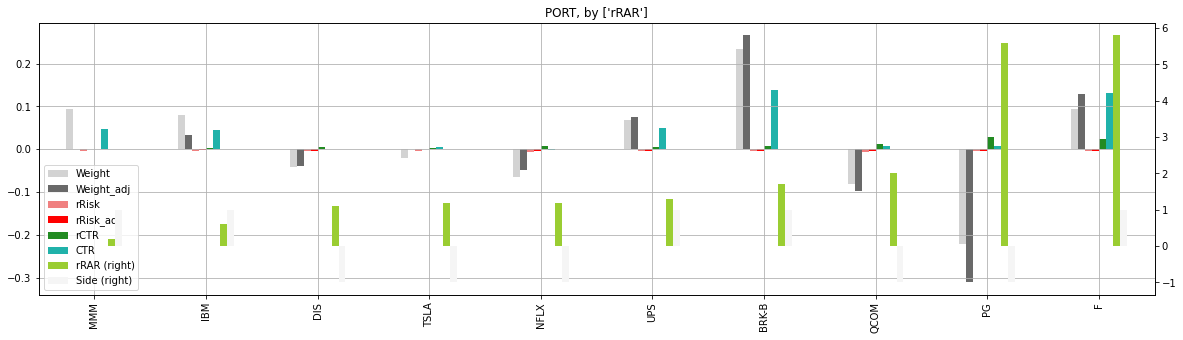

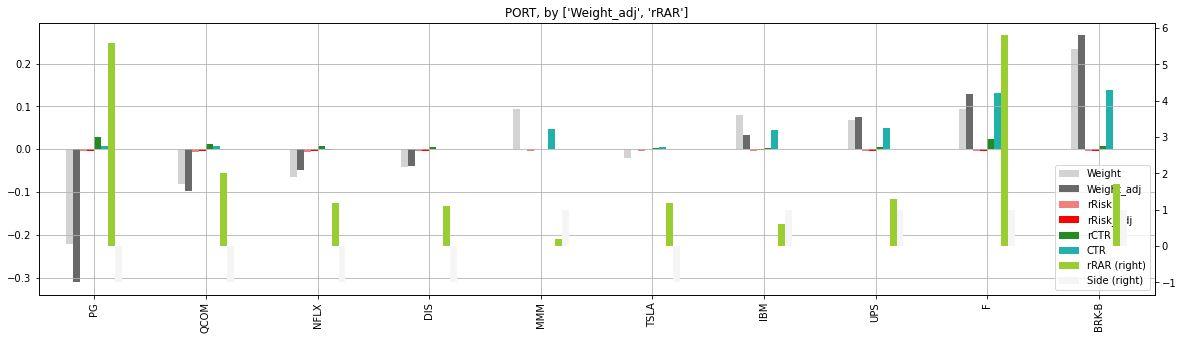

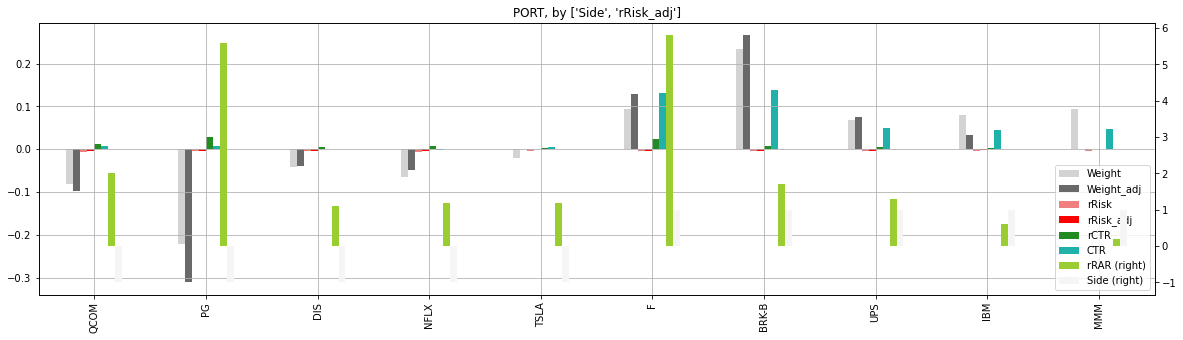

In [16]:
bar_cols= ['Weight', 'Weight_adj','rRisk','rRisk_adj','rCTR', 'CTR','rRAR','Side']
col_style= ['lightgrey','dimgrey','lightcoral','red',
            'forestgreen','lightseagreen','yellowgreen','whitesmoke' ]
sort_keys= ['Weight_adj','rCTR']
sec_y=['rRAR','Side']

sort= ['rRAR']
port[bar_cols].sort_values(by=sort).plot(kind='bar',
            grid=True,figsize=(20,5),
            secondary_y=sec_y,color=col_style, title= 'PORT, by '+str(sort))

sort= ['Weight_adj','rRAR']
port[bar_cols].sort_values(by=sort).plot(kind='bar',
            grid=True,figsize=(20,5),
            secondary_y=sec_y,color=col_style, title= 'PORT, by '+str(sort))

sort= ['Side','rRisk_adj']
port[bar_cols].sort_values(by=sort).plot(kind='bar',
            grid=True,figsize=(20,5),
            secondary_y=sec_y,color=col_style, title= 'PORT, by '+str(sort))
